In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random 
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

from prognet import *
from utils import *

In [2]:
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

torch.backends.cudnn.deterministic = True 
manualSeed = 42
random.seed(manualSeed)
torch.manual_seed(manualSeed)
print("Random Seed: ",manualSeed)


cuda:0
Random Seed:  42


# MNIST Classification

In [3]:
def make_column(activated = True): 
    if activated: 
        model = nn.Sequential(nn.Linear(28*28*1,128),
                      nn.ReLU(),
                      nn.Linear(128,64),
                      nn.ReLU(), 
                      nn.Linear(64,32),
                      nn.ReLU(),
                      nn.Linear(32,10))
    else: 
        model = nn.Sequential(nn.Linear(28*28*1,128),
                      #nn.ReLU(),
                      nn.Linear(128,64),
                      #nn.ReLU(), 
                      nn.Linear(64,32),
                      #nn.ReLU(),
                      nn.Linear(32,10))
    return model
shapes_activated = [128,128,64,64,32,32,10]
shapes = [128,64,32,10]


In [4]:
in_size = 28*28*1
out_shapes = [128,64,32,10]
prog_net = ProgNetSimple()
dummy_net = make_column(activated = True).to(device)
prog_net.new_task(in_size = in_size, out_shapes = out_shapes)
prog_net = prog_net.to(device)


params = sum(p.numel() for p in prog_net.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(prog_net)

Total number of parameters is: 111146
ProgNetSimple(
  (columns): ModuleList(
    (0): ModuleList(
      (0): LateralBlock(
        (block): Linear(in_features=784, out_features=128, bias=True)
        (u): ModuleList()
      )
      (1): LateralBlock(
        (block): Linear(in_features=128, out_features=64, bias=True)
        (u): ModuleList()
      )
      (2): LateralBlock(
        (block): Linear(in_features=64, out_features=32, bias=True)
        (u): ModuleList()
      )
      (3): LateralBlock(
        (block): Linear(in_features=32, out_features=10, bias=True)
        (u): ModuleList()
      )
    )
  )
)


In [5]:
digits_0 = [0,1,2,3,4]
digits_1 = [5,6,7,8,9]
digits_full = list(range(10))

train_batch_size = 64
test_batch_size = 1000

train_loader_0 = dataloader_MNIST(folder = './data',
                                batch_size = train_batch_size,
                                train = True, 
                                digits = digits_0)
test_loader_0 = dataloader_MNIST(folder = './data',
                                batch_size = test_batch_size,
                                train = False, 
                                digits = digits_0)

train_loader_1 = dataloader_MNIST(folder = './data',
                                batch_size = train_batch_size,
                                train = True, 
                                digits = digits_1)
test_loader_1 = dataloader_MNIST(folder = './data',
                                batch_size = test_batch_size,
                                train = False, 
                                digits = digits_1)

test_loader_full = dataloader_MNIST(folder = './data',
                                batch_size = test_batch_size,
                                train = False, 
                                digits = digits_full)

### Training phase  1 
Column 0, digits 0 to 4

In [6]:
#Training parameters
learning_rate = 0.0001
num_epochs = 10

optimizer = optim.Adam(prog_net.parameters(),
                       lr = learning_rate)
optimizer_d = optim.Adam(dummy_net.parameters(),
                       lr = learning_rate)
criterion = F.cross_entropy

In [7]:
train_loss_pn = []
test_loss_pn_full = []
test_loss_pn_0 = []
test_loss_pn_1 = []

train_loss_d = []
test_loss_d_full = []
test_loss_d_0 = []
test_loss_d_1 = []

In [8]:
for epoch in tqdm(range(num_epochs)):
    #update prog_net
    train_loss_pn.append(train(model = prog_net,
                           dataloader = train_loader_0,
                           criterion = criterion, 
                           optimizer = optimizer, 
                           device = device))
    
    test_loss_pn_full.append(model_eval(model = prog_net,
                               dataloader = test_loader_full, 
                               criterion = criterion,
                               device = device))
    test_loss_pn_0.append(model_eval(model = prog_net,
                               dataloader = test_loader_0, 
                               criterion = criterion,
                               device = device))
    test_loss_pn_1.append(model_eval(model = prog_net,
                               dataloader = test_loader_1, 
                               criterion = criterion,
                               device = device))
    #update dummy_net
    train_loss_d.append(train(model = dummy_net,
                           dataloader = train_loader_0,
                           criterion = criterion, 
                           optimizer = optimizer_d, 
                           device = device))
    
    test_loss_d_full.append(model_eval(model = dummy_net,
                               dataloader = test_loader_full, 
                               criterion = criterion,
                               device = device))
    test_loss_d_0.append(model_eval(model = dummy_net,
                               dataloader = test_loader_0, 
                               criterion = criterion,
                               device = device))
    test_loss_d_1.append(model_eval(model = dummy_net,
                               dataloader = test_loader_1, 
                               criterion = criterion,
                               device = device))

100%|██████████| 10/10 [02:26<00:00, 14.62s/it]


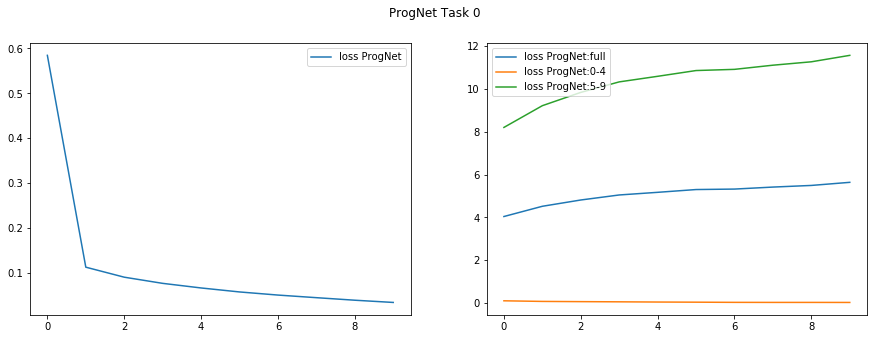

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (15,5))

fig.suptitle('ProgNet Task 0')

ax1.plot(list(range(0,len(train_loss_pn))), train_loss_pn, label='loss ProgNet')
ax2.plot(list(range(0,len(test_loss_pn_full))), test_loss_pn_full, label='loss ProgNet:full')
ax2.plot(list(range(0,len(test_loss_pn_0))), test_loss_pn_0, label='loss ProgNet:0-4')
ax2.plot(list(range(0,len(test_loss_pn_1))), test_loss_pn_1, label='loss ProgNet:5-9')

ax1.legend()
ax2.legend()
plt.show()

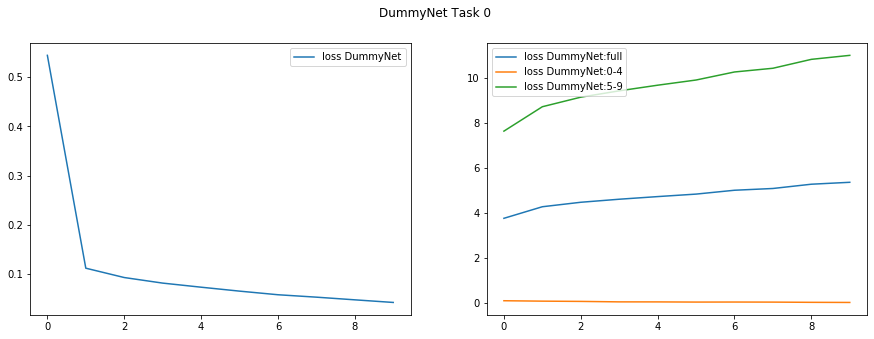

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (15,5))

fig.suptitle('DummyNet Task 0')

ax1.plot(list(range(0,len(train_loss_d))), train_loss_d, label='loss DummyNet')
ax2.plot(list(range(0,len(test_loss_d_full))), test_loss_d_full, label='loss DummyNet:full')
ax2.plot(list(range(0,len(test_loss_d_0))), test_loss_d_0, label='loss DummyNet:0-4')
ax2.plot(list(range(0,len(test_loss_d_1))), test_loss_d_1, label='loss DummyNet:5-9')
ax1.legend()
ax2.legend()
plt.show()

### Training Phase 2
Column 1, digits 5 to 9

In [11]:
prog_net.freeze_columns()
prog_net.new_task(in_size,out_shapes)
prog_net = prog_net.to(device)

params = sum(p.numel() for p in prog_net.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(prog_net)

Total number of parameters is: 121812
ProgNetSimple(
  (columns): ModuleList(
    (0): ModuleList(
      (0): LateralBlock(
        (block): Linear(in_features=784, out_features=128, bias=True)
        (u): ModuleList()
      )
      (1): LateralBlock(
        (block): Linear(in_features=128, out_features=64, bias=True)
        (u): ModuleList()
      )
      (2): LateralBlock(
        (block): Linear(in_features=64, out_features=32, bias=True)
        (u): ModuleList()
      )
      (3): LateralBlock(
        (block): Linear(in_features=32, out_features=10, bias=True)
        (u): ModuleList()
      )
    )
    (1): ModuleList(
      (0): LateralBlock(
        (block): Linear(in_features=784, out_features=128, bias=True)
        (u): ModuleList()
      )
      (1): LateralBlock(
        (block): Linear(in_features=128, out_features=64, bias=True)
        (u): ModuleList(
          (0): Linear(in_features=128, out_features=64, bias=True)
        )
      )
      (2): LateralBlock(
     

In [12]:
#Training
learning_rate = 0.0001
num_epochs = 10

optimizer = optim.Adam(prog_net.parameters(),
                       lr = learning_rate)
optimizer_d = optim.Adam(dummy_net.parameters(),
                       lr = learning_rate)
criterion = F.cross_entropy

In [13]:
for epoch in tqdm(range(num_epochs)):
    #update prog_net
    train_loss_pn.append(train(model = prog_net,
                           dataloader = train_loader_1,
                           criterion = criterion, 
                           optimizer = optimizer, 
                           device = device))
    
    test_loss_pn_full.append(model_eval(model = prog_net,
                               dataloader = test_loader_full, 
                               criterion = criterion,
                               device = device))
    test_loss_pn_0.append(model_eval(model = prog_net,
                               dataloader = test_loader_0, 
                               criterion = criterion,
                               device = device,
                               task_id = 0))
    test_loss_pn_1.append(model_eval(model = prog_net,
                               dataloader = test_loader_1, 
                               criterion = criterion,
                               device = device))
    #update dummy_net
    train_loss_d.append(train(model = dummy_net,
                           dataloader = train_loader_1,
                           criterion = criterion, 
                           optimizer = optimizer_d, 
                           device = device))
    
    test_loss_d_full.append(model_eval(model = dummy_net,
                               dataloader = test_loader_full, 
                               criterion = criterion,
                               device = device))
    test_loss_d_0.append(model_eval(model = dummy_net,
                               dataloader = test_loader_0, 
                               criterion = criterion,
                               device = device))
    test_loss_d_1.append(model_eval(model = dummy_net,
                               dataloader = test_loader_1, 
                               criterion = criterion,
                               device = device))

100%|██████████| 10/10 [02:46<00:00, 16.61s/it]


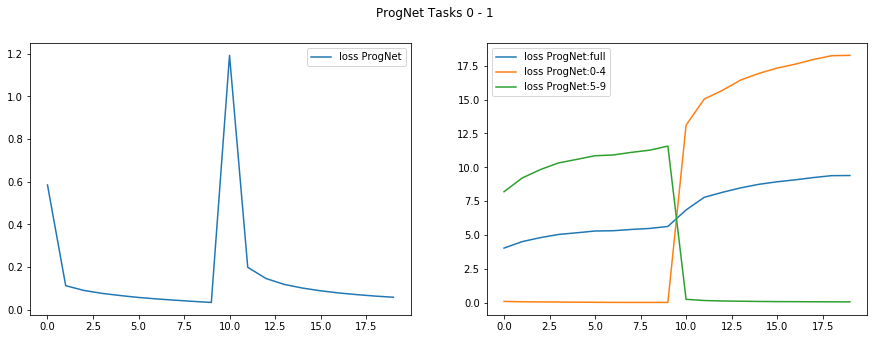

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (15,5))

fig.suptitle('ProgNet Tasks 0 - 1')

ax1.plot(list(range(0,len(train_loss_pn))), train_loss_pn, label='loss ProgNet')
ax2.plot(list(range(0,len(test_loss_pn_full))), test_loss_pn_full, label='loss ProgNet:full')
ax2.plot(list(range(0,len(test_loss_pn_0))), test_loss_pn_0, label='loss ProgNet:0-4')
ax2.plot(list(range(0,len(test_loss_pn_1))), test_loss_pn_1, label='loss ProgNet:5-9')

ax1.legend()
ax2.legend()
plt.show()


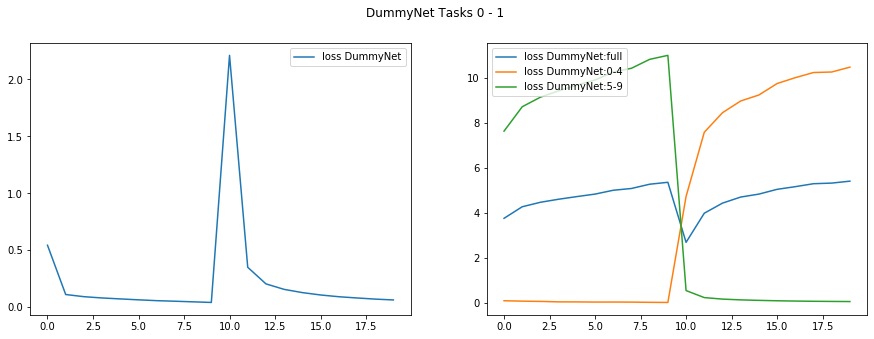

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (15,5))

fig.suptitle('DummyNet Tasks 0 - 1')

ax1.plot(list(range(0,len(train_loss_d))), train_loss_d, label='loss DummyNet')
ax2.plot(list(range(0,len(test_loss_d_full))), test_loss_d_full, label='loss DummyNet:full')
ax2.plot(list(range(0,len(test_loss_d_0))), test_loss_d_0, label='loss DummyNet:0-4')
ax2.plot(list(range(0,len(test_loss_d_1))), test_loss_d_1, label='loss DummyNet:5-9')
ax1.legend()
ax2.legend()
plt.show()


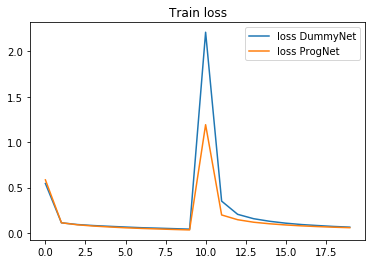

In [16]:

plt.plot(list(range(0,len(train_loss_d))), train_loss_d, label='loss DummyNet')
plt.plot(list(range(0,len(train_loss_pn))), train_loss_pn, label='loss ProgNet')
plt.title('Train loss')
plt.legend()
plt.show()

In [17]:
prog_net.columns[0]

ModuleList(
  (0): LateralBlock(
    (block): Linear(in_features=784, out_features=128, bias=True)
    (u): ModuleList()
  )
  (1): LateralBlock(
    (block): Linear(in_features=128, out_features=64, bias=True)
    (u): ModuleList()
  )
  (2): LateralBlock(
    (block): Linear(in_features=64, out_features=32, bias=True)
    (u): ModuleList()
  )
  (3): LateralBlock(
    (block): Linear(in_features=32, out_features=10, bias=True)
    (u): ModuleList()
  )
)

## Classification with ProgNet: random weights for column 0

In [18]:
prog_net_random = copy.deepcopy(prog_net).to(device)

for params in prog_net_random.columns[0].parameters():
    params.copy_(torch.rand_like(params))


In [19]:
test_pn = model_eval(model = prog_net,
                               dataloader = test_loader_1, 
                               criterion = criterion,
                               device = device,
                               task_id = 1)
test_pnr = model_eval(model = prog_net_random,
                               dataloader = test_loader_1, 
                               criterion = criterion,
                               device = device,
                               task_id = 1)

print('(ProgNet) test loss:{:.4f}, (ProgNet + random col 0) test loss:{:.4f}'.format(test_pn,test_pnr))

(ProgNet) test loss:0.0732, (ProgNet + random col 0) test loss:30823.8336


In [20]:
data,_ = next(iter(test_loader_1))
data = data.to(device)


In [21]:
prog_net.eval()
(prog_net(data) < 0).sum()

tensor(5764, device='cuda:0')

In [22]:
dummy_net.eval()
(dummy_net(data) < 0).sum()

tensor(8343, device='cuda:0')